# Midterm Project Report - Data Science in Practice

## Importing the relevent libraries to handle dataframes, timeseries and NLP

In [1]:
import pandas as pd 
import numpy as np
import datetime as dt 
from twitterscraper import query_tweets
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from langdetect import detect 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.mlab as mlab

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

C:\Users\anura\Anaconda3\lib\site-packages\past\types\oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable


### The data is a JSON file that contains twitter data from April 2018 to April 2020 with the keyword 'boeing'
#### By using the timestamp, we can get the date on which these tweets were recieved.
#### Then Vader Sentiment Analysis was performed on the text of the tweets to get a sentiment score of the text.
#### Now we have a positive, negetive and neutral intensity score on each of the tweets. We can see the intensity of each of those three catrgories on these tweets

In [2]:
df = pd.read_json('b1_tweets.json')
df['date'] = df['timestamp'].apply(lambda x: x.date())

analyzer = SentimentIntensityAnalyzer()
sentiment = df['text'].apply(lambda x: analyzer.polarity_scores(x))
df = pd.concat([df, sentiment.apply(pd.Series)],1)

#### As we can see, there are 13992 tweets, with various fields such as likes, replies and retweets in addition to the sentiment score. 

In [3]:
df.describe()

,likes,replies,retweets,tweet_id,user_id,neg,neu,pos,compound
count,13992.000000,13992.000000,13992.000000,1.399200e+04,1.399200e+04,13992.000000,13992.000000,13992.00000,13992.000000
mean,7.790166,0.510292,2.721269,1.116743e+18,2.505918e+17,0.046466,0.896781,0.05468,0.023894
std,331.319281,13.818117,147.137668,3.727777e+16,4.178156e+17,0.090280,0.135877,0.09933,0.371964
min,0.000000,0.000000,0.000000,1.052979e+18,9.880000e+02,0.000000,0.000000,0.00000,-0.979000
25%,0.000000,0.000000,0.000000,1.085961e+18,1.164795e+08,0.000000,0.817000,0.00000,0.000000
50%,0.000000,0.000000,0.000000,1.118968e+18,9.179110e+08,0.000000,0.954000,0.00000,0.000000
75%,1.000000,0.000000,0.000000,1.145480e+18,7.375687e+17,0.064000,1.000000,0.09100,0.153100
max,38538.000000,1539.000000,17305.000000,1.178822e+18,1.178711e+18,1.000000,1.000000,1.00000,0.994600


#### Here is the plot to see how the various sentiments change over time. As we can see, there is a decrease in the compound sentiment. That shows that there is a change in sentiment that takes place around March 2019. This coincides with the FAA grounding the fleet worldwide on March 13th 2019.
#### The next step is to label all tweets on the date before and after March 13th 2019

C:\Users\anura\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Sentiment')

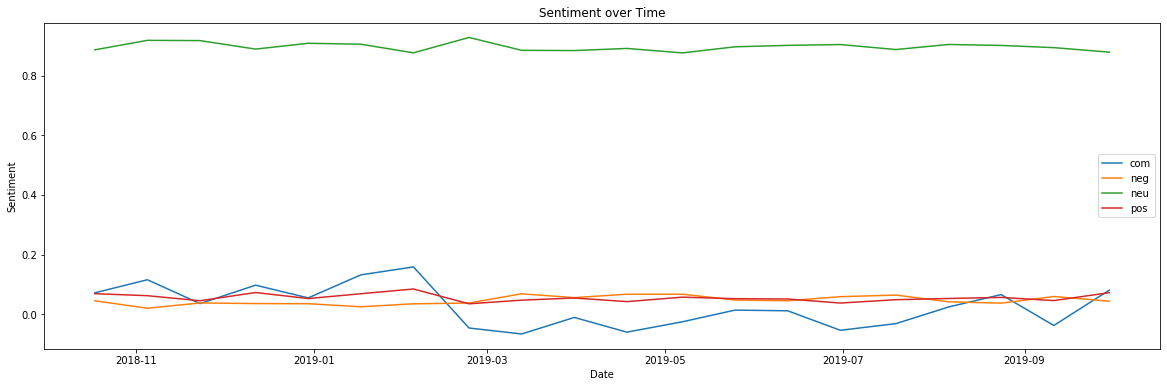

In [4]:
plt.figure(figsize = (20,6))
plt.plot(df.groupby('date').mean()['compound'].index, df.groupby('date').mean()['compound'].values, label = 'com')
plt.plot(df.groupby('date').mean()['neg'].index, df.groupby('date').mean()['neg'].values, label = 'neg')
plt.plot(df.groupby('date').mean()['neu'].index, df.groupby('date').mean()['neu'].values, label = 'neu')
plt.plot(df.groupby('date').mean()['pos'].index, df.groupby('date').mean()['pos'].values, label = 'pos')

plt.legend(loc = 'best')
plt.title('Sentiment over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment')

Text(0, 0.5, 'Sentiment')

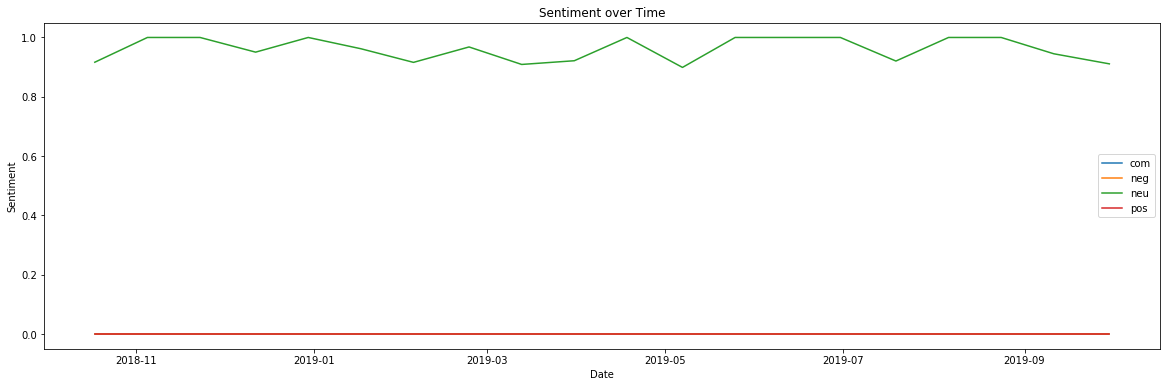

In [5]:
plt.figure(figsize = (20,6))
plt.plot(df.groupby('date').median()['compound'].index, df.groupby('date').median()['compound'].values, label = 'com')
plt.plot(df.groupby('date').median()['neg'].index, df.groupby('date').median()['neg'].values, label = 'neg')
plt.plot(df.groupby('date').median()['neu'].index, df.groupby('date').median()['neu'].values, label = 'neu')
plt.plot(df.groupby('date').median()['pos'].index, df.groupby('date').median()['pos'].values, label = 'pos')

plt.legend(loc = 'best')
plt.title('Sentiment over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment')

#### Here, by using groupby, the sentiment scores of all tweets on the same day can be combined by using mean 

In [6]:
Table = df.groupby('date').mean()

In [7]:
Table.describe()

,has_media,is_replied,is_reply_to,likes,replies,retweets,tweet_id,user_id,neg,neu,pos,compound
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,2.000000e+01,2.000000e+01,20.000000,20.000000,20.000000,20.000000
mean,0.229931,0.172743,0.217040,7.839757,0.512906,2.732356,1.115802e+18,2.516979e+17,0.046187,0.896570,0.055187,0.026321
std,0.040976,0.035115,0.067074,12.281071,0.538419,5.597179,3.913553e+16,3.709258e+16,0.014250,0.014495,0.012796,0.068369
min,0.133903,0.107496,0.042350,2.594972,0.209335,0.699721,1.053022e+18,1.910518e+17,0.019849,0.876098,0.034777,-0.066414
25%,0.206530,0.144465,0.200085,2.970909,0.309229,0.938237,1.084345e+18,2.241505e+17,0.036558,0.885936,0.046650,-0.033247
50%,0.234927,0.182795,0.221285,5.002278,0.372271,1.239794,1.115725e+18,2.538704e+17,0.044242,0.895161,0.052479,0.018838
75%,0.260957,0.193229,0.261438,5.998378,0.434336,1.840406,1.147159e+18,2.876878e+17,0.058745,0.904563,0.063599,0.073896
max,0.295359,0.231332,0.328488,58.095442,2.582621,26.246439,1.178772e+18,3.065292e+17,0.068237,0.927844,0.084382,0.158437


In [8]:
Table['Label'] = (dt.date(2019, 3, 13) > Table.index.values)*1

In [9]:
Table.head()

,has_media,is_replied,is_reply_to,likes,replies,retweets,tweet_id,user_id,neg,neu,pos,compound,Label
date,,,,,,,,,,,,,
2018-10-18,0.295359,0.185654,0.257384,6.130802,0.426160,1.938819,1.053022e+18,2.881006e+17,0.044956,0.886331,0.068726,0.071634,1
2018-11-05,0.277383,0.133713,0.125178,2.792319,0.244666,0.914651,1.059529e+18,2.071009e+17,0.019849,0.918175,0.061962,0.115379,1
2018-11-23,0.235695,0.133515,0.117166,4.125341,0.389646,1.085831,1.066031e+18,1.910518e+17,0.037659,0.917332,0.045004,0.035400,1
2018-12-12,0.284639,0.186747,0.222892,3.635542,0.311747,1.013554,1.072939e+18,2.362577e+17,0.035550,0.888843,0.072608,0.097224,1
2018-12-30,0.248945,0.177215,0.218003,4.627286,0.381153,1.710267,1.079418e+18,2.687910e+17,0.035058,0.908363,0.052367,0.054535,1


In [10]:
from statsmodels.formula.api import logit
formula = 'Label ~ neg + pos + compound'
model_1 = logit(formula, Table).fit()
print(model_1.summary())

Table['Prediction'] = (model_1.predict(Table) > 0.5)*1

print('The Accuracy is:',(Table['Label'] == Table['Prediction']).mean()*100)

Optimization terminated successfully.
         Current function value: 0.260342
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                  Label   No. Observations:                   20
Model:                          Logit   Df Residuals:                       16
Method:                           MLE   Df Model:                            3
Date:                Fri, 21 Aug 2020   Pseudo R-squ.:                  0.6132
Time:                        12:38:48   Log-Likelihood:                -5.2068
converged:                       True   LL-Null:                       -13.460
Covariance Type:            nonrobust   LLR p-value:                 0.0008925
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.9773      8.059      1.610      0.107      -2.818      28.772
neg         -456.4854    295

#### As we can see, the accuracy is high. This plot will show the days that were predicted incorrectly

Text(0, 0.5, 'Above = 0, Before = 1')

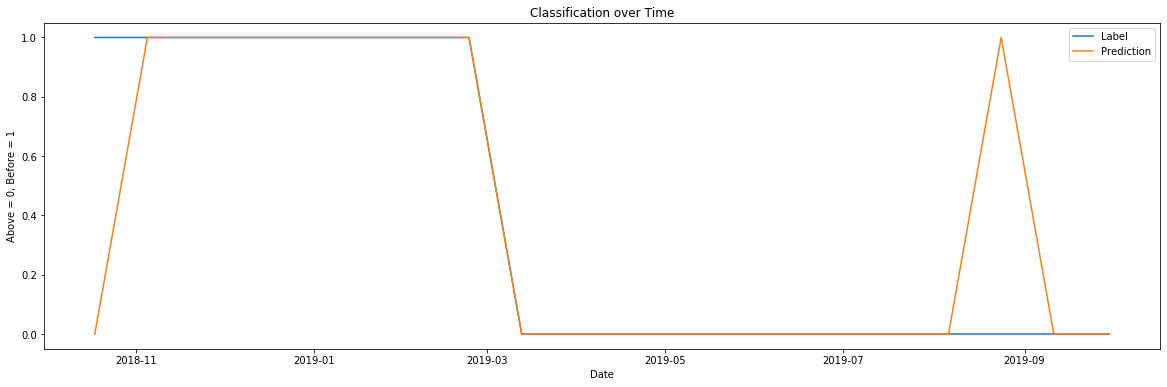

In [11]:
Table['Prediction'] = (model_1.predict(Table) > 0.5)*1

plt.figure(figsize = (20,6))
plt.plot(Table['Label'].index, Table['Label'].values, label = 'Label')
plt.plot(Table.index, Table['Prediction'].values, label = 'Prediction')

plt.legend(loc = 'best')
plt.title('Classification over Time')
plt.xlabel('Date')
plt.ylabel('Above = 0, Before = 1')

# Now, we can run this on the larger database

In [12]:
df_b1 = pd.read_json('b737max_1_tweets.json')
df_b2 = pd.read_json('b737max_2_tweets.json')
df_b3 = pd.read_json('b737max_3_tweets.json')
df_b4 = pd.read_json('b737max_4_tweets.json')
df_b5 = pd.read_json('b737max_5_tweets.json')
df_b6 = pd.read_json('b737max_6_tweets.json')
df_b7 = pd.read_json('b737max_7_tweets.json')
df_b8 = pd.read_json('b737max_8_tweets.json')
df_b9 = pd.read_json('b737max_9_tweets.json')

df_full = pd.concat([df_b1,df_b2,df_b3,df_b4,df_b5,df_b6,df_b7,df_b8,df_b9])
df_full = df_full.drop_duplicates(subset = ['tweet_id'])
sentiment = df_full['text'].apply(lambda x: analyzer.polarity_scores(x))
df_full = pd.concat([df_full, sentiment.apply(pd.Series)],1)
df_full['date'] = df_full['timestamp'].apply(lambda x: x.date())

In [13]:
Table_full = df_full.groupby('date').mean()

In [14]:
Table_full.describe()

,has_media,is_replied,is_reply_to,likes,replies,retweets,tweet_id,user_id,neg,neu,pos,compound
count,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,2.390000e+02,2.390000e+02,239.000000,239.000000,239.000000,239.000000
mean,0.272034,0.125457,0.079302,5.096763,0.347409,1.535366,1.122457e+18,2.279295e+17,0.041884,0.919283,0.038834,-0.012462
std,0.118295,0.055058,0.096677,6.135220,0.560119,2.084418,6.296809e+16,8.301223e+16,0.033846,0.043410,0.020062,0.110271
min,0.000000,0.000000,0.000000,0.192308,0.000000,0.076923,1.046777e+18,2.997331e+16,0.000000,0.731895,0.000000,-0.360013
25%,0.183291,0.090442,0.026951,1.823933,0.153010,0.674447,1.073004e+18,1.760874e+17,0.010438,0.891916,0.027128,-0.089209
50%,0.250000,0.121001,0.054545,2.841945,0.245856,0.968379,1.094563e+18,2.226445e+17,0.039614,0.923622,0.036141,-0.000869
75%,0.350000,0.155777,0.089134,5.765110,0.371711,1.665635,1.176680e+18,2.648060e+17,0.063156,0.954927,0.047589,0.068348
max,0.631579,0.285714,0.511628,47.801418,7.703704,25.418440,1.244982e+18,5.855238e+17,0.157326,0.992947,0.143737,0.258380


Text(0, 0.5, 'Sentiment')

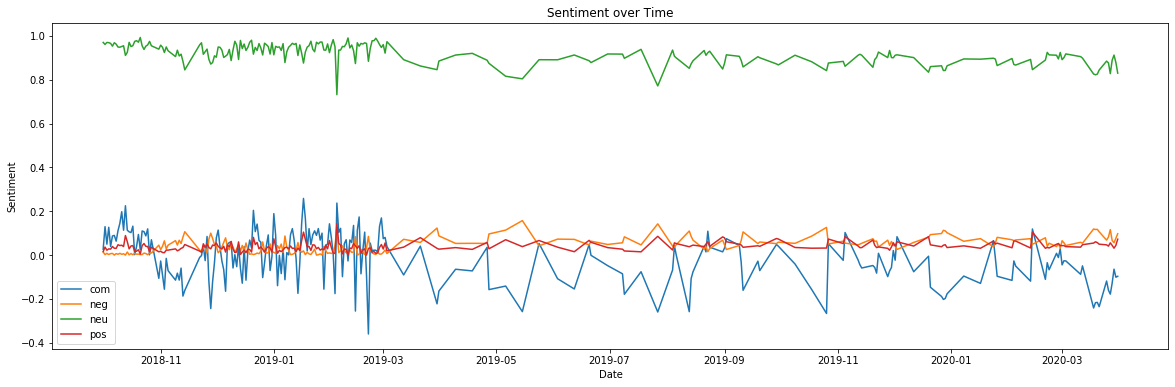

In [15]:
#Plotting the change in sentiment over time
plt.figure(figsize = (20,6))
plt.plot(Table_full['compound'].index, Table_full['compound'].values, label = 'com')
plt.plot(Table_full['neg'].index, Table_full['neg'].values, label = 'neg')
plt.plot(Table_full['neu'].index, Table_full['neu'].values, label = 'neu')
plt.plot(Table_full['pos'].index, Table_full['pos'].values, label = 'pos')

plt.legend(loc = 'best')
plt.title('Sentiment over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment')

In [16]:
Table_full.head()

,has_media,is_replied,is_reply_to,likes,replies,retweets,tweet_id,user_id,neg,neu,pos,compound
date,,,,,,,,,,,,
2018-10-01,0.564103,0.102564,0.025641,6.794872,1.076923,2.205128,1.046777e+18,1.350185e+17,0.013718,0.970385,0.015897,0.026762
2018-10-02,0.244898,0.102041,0.081633,2.122449,0.163265,0.469388,1.047149e+18,4.387289e+17,0.002367,0.961143,0.036490,0.129584
2018-10-03,0.423077,0.269231,0.115385,7.500000,0.615385,2.692308,1.047464e+18,1.443181e+17,0.007615,0.970154,0.022231,0.049731
2018-10-04,0.361111,0.111111,0.111111,6.361111,0.361111,1.277778,1.047851e+18,1.088065e+17,0.002556,0.969222,0.028250,0.126808
2018-10-05,0.379310,0.034483,0.068966,4.689655,0.034483,0.793103,1.048163e+18,1.491442e+17,0.006655,0.966138,0.027207,0.039641


Text(0, 0.5, 'Sentiment')

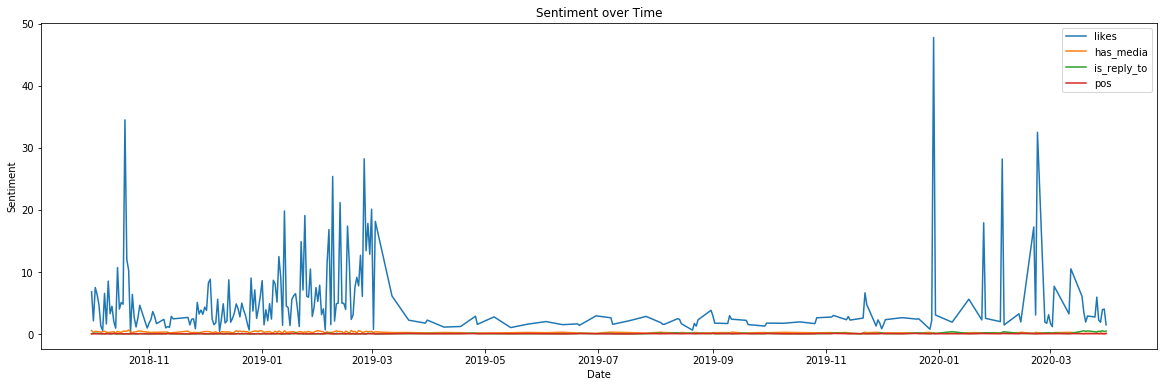

In [17]:
#Plotting the change in sentiment over time
plt.figure(figsize = (20,6))
plt.plot(Table_full['likes'].index, Table_full['likes'].values, label = 'likes')
plt.plot(Table_full['has_media'].index, Table_full['has_media'].values, label = 'has_media')
plt.plot(Table_full['is_reply_to'].index, Table_full['is_reply_to'].values, label = 'is_reply_to')
plt.plot(Table_full['pos'].index, Table_full['pos'].values, label = 'pos')

plt.legend(loc = 'best')
plt.title('Sentiment over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment')

In [18]:
Table_full['Label'] = (dt.date(2019, 3, 13) > Table_full.index.values)*1

In [19]:
Table_full.columns

Index(['has_media', 'is_replied', 'is_reply_to', 'likes', 'replies',
       'retweets', 'tweet_id', 'user_id', 'neg', 'neu', 'pos', 'compound',
       'Label'],
      dtype='object')

In [20]:
formula = 'Label~ has_media + is_replied + is_reply_to + likes + replies + retweets + neg + neu + pos'
model_1 = logit(formula, Table_full).fit()
print(model_1.summary())

Table_full['Prediction'] = (model_1.predict(Table_full) > 0.5)*1

print('The Accuracy is:',(Table_full['Label'] == Table_full['Prediction']).mean()*100)

         Current function value: 0.836769
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                  Label   No. Observations:                  239
Model:                          Logit   Df Residuals:                      229
Method:                           MLE   Df Model:                            9
Date:                Fri, 21 Aug 2020   Pseudo R-squ.:                 -0.2391
Time:                        12:39:08   Log-Likelihood:                -199.99
converged:                      False   LL-Null:                       -161.40
Covariance Type:            nonrobust   LLR p-value:                     1.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -2.136e+05   4.74e+04     -4.507      0.000   -3.07e+05   -1.21e+05
has_media      18.8255      6.219      3.027      0.002       

C:\Users\anura\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [21]:
formula = 'Label ~ compound + has_media + is_reply_to'
model_2 = logit(formula, Table_full).fit()
print(model_2.summary())

Table_full['Prediction'] = (model_2.predict(Table_full) > 0.5)*1

print('The Accuracy is:',(Table_full['Label'] == Table_full['Prediction']).mean()*100)

Optimization terminated successfully.
         Current function value: 0.328963
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  Label   No. Observations:                  239
Model:                          Logit   Df Residuals:                      235
Method:                           MLE   Df Model:                            3
Date:                Fri, 21 Aug 2020   Pseudo R-squ.:                  0.5129
Time:                        12:39:08   Log-Likelihood:                -78.622
converged:                       True   LL-Null:                       -161.40
Covariance Type:            nonrobust   LLR p-value:                 1.159e-35
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -1.9466      0.816     -2.385      0.017      -3.546      -0.347
compound        4.5439    

Text(0, 0.5, 'Above = 0, Before = 1')

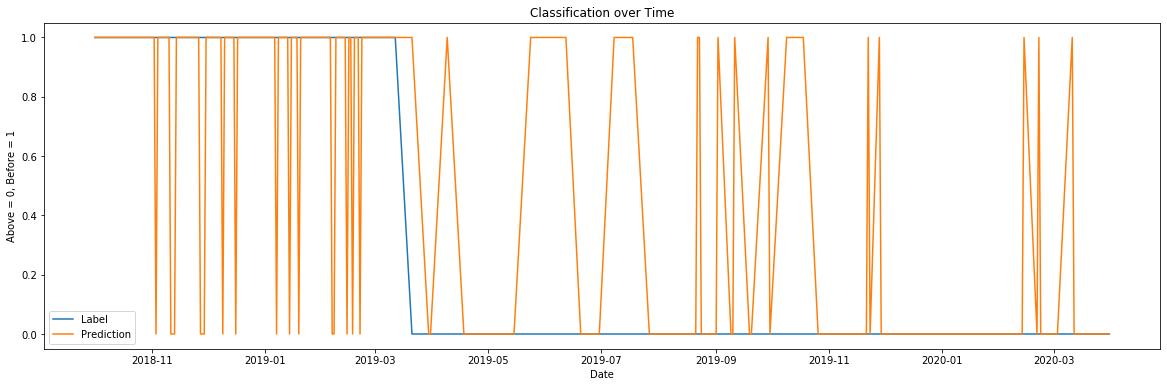

In [22]:
plt.figure(figsize = (20,6))
plt.plot(Table_full['Label'].index, Table_full['Label'].values, label = 'Label')
plt.plot(Table_full.index, Table_full['Prediction'].values, label = 'Prediction')

plt.legend(loc = 'best')
plt.title('Classification over Time')
plt.xlabel('Date')
plt.ylabel('Above = 0, Before = 1')

In [23]:
Table_full['Correct_Prediction'] = (Table_full['Label'] == Table_full['Prediction'] )

Text(0, 0.5, 'Above = Correct, Before = Incorrect')

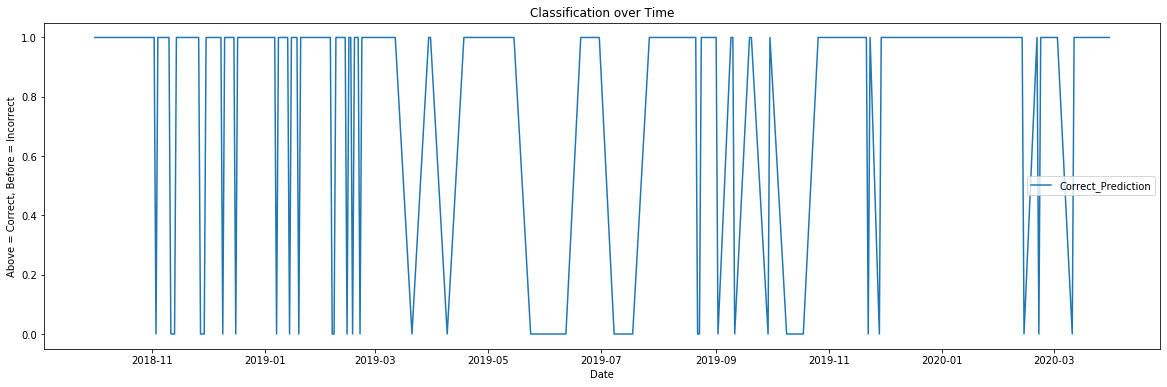

In [24]:
plt.figure(figsize = (20,6))
plt.plot(Table_full['Correct_Prediction'].index, Table_full['Correct_Prediction'].values, label = 'Correct_Prediction')

plt.legend(loc = 'best')
plt.title('Classification over Time')
plt.xlabel('Date')
plt.ylabel('Above = Correct, Before = Incorrect')